### 1. Clip the EMIT and PlanetScope imagery to SHIFT campaign region

In [2]:
#environment: py39 in my miniconda
import geopandas as gpd
import warnings
warnings.filterwarnings("ignore")
from osgeo import gdal,gdalconst

data_path = "/130TB_raid0/fujiang/SmallSat_part2/1_imagery_data/"
shp = f"{data_path}0_shp/1_clip.shp"
emit = f"{data_path}EMIT_L2A_RFL_20230422.tif"
planet = f"{data_path}PlanetScope_RFL_20230422.tif"

gdf = gpd.read_file(shp)
bounds = gdf.bounds
min_x = bounds["minx"].values[0]
min_y = bounds["miny"].values[0]
max_x = bounds["maxx"].values[0]
max_y = bounds["maxy"].values[0]
ul_x, ul_y = (min_x, max_y)
lr_x, lr_y = (max_x, min_y)

dataset = gdal.Open(planet)
geotransform = dataset.GetGeoTransform()
ul_x2 = geotransform[0]
ul_y2 = geotransform[3]
cols = dataset.RasterXSize
rows = dataset.RasterYSize
lr_x2 = ul_x2 + (cols * geotransform[1])
lr_y2 = ul_y2 + (rows * geotransform[5])

ul_x_new = max(ul_x, ul_x2)
ul_y_new = min(ul_y, ul_y2)
lr_x_new = min(lr_x, lr_x2)
lr_y_new = max(lr_y, lr_y2)

# out_tif = f"{emit[:-4]}_clipped.tif"
# gdal.Warp(out_tif, emit, outputBounds=(ul_x_new, lr_y_new, lr_x_new, ul_y_new), cropToCutline=True, format='GTiff')
# out_tif = f"{planet[:-4]}_clipped.tif"
# gdal.Warp(out_tif, planet, outputBounds=(ul_x_new, lr_y_new, lr_x_new, ul_y_new), cropToCutline=True, format='GTiff')

print(ul_x_new, lr_x_new, lr_y_new, ul_y_new)

174714.77272756316 193347.5743273191 3816019.5146135557 3843232.8023862587


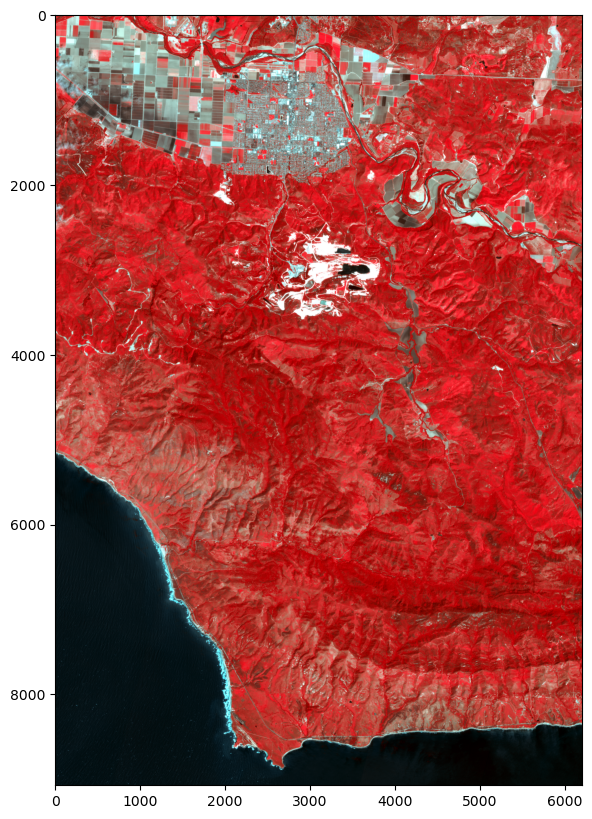

In [6]:
import numpy as np
def read_tif(tif_file):
    dataset = gdal.Open(tif_file)
    cols = dataset.RasterXSize
    rows = dataset.RasterYSize
    im_proj = (dataset.GetProjection())
    im_Geotrans = (dataset.GetGeoTransform())
    im_data = dataset.ReadAsArray(0, 0, cols, rows)
    if im_data.ndim == 3:
        im_data = np.moveaxis(dataset.ReadAsArray(0, 0, cols, rows), 0, -1)
    return im_data, im_Geotrans, im_proj,rows, cols


out_tif = f"{planet[:-4]}_clipped.tif"
im_data, im_Geotrans, im_proj,rows, cols = read_tif(out_tif)

rgb = im_data[:,:, [7,5,3]].astype(np.float32)
for i in range(3):
    band = rgb[:, :, i]
    p2, p98 = np.percentile(band, (1, 99))
    rgb[:, :, i] = np.clip((band - p2) / (p98 - p2), 0, 1)
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize = (10,10), dpi = 100)
ax.imshow(rgb)

# out_tif = f"{emit[:-4]}_clipped.tif"
# im_data, im_Geotrans, im_proj,rows, cols = read_tif(out_tif)
# rgb = im_data[:,:, [36, 27, 15]].astype(np.float32)
# rgb = im_data[:,:, [7,5,3]].astype(np.float32)
# for i in range(3):
#     band = rgb[:, :, i]
#     p2, p98 = np.percentile(band, (1, 99))
#     rgb[:, :, i] = np.clip((band - p2) / (p98 - p2), 0, 1)
# import matplotlib.pyplot as plt
# fig,ax = plt.subplots(figsize = (10,10), dpi = 100)
# ax.imshow(rgb)

### 2. Pixel and spectral resample and applied to fusion model.

In [1]:
#environment: Fujiang in my miniconda
import os
import torch
import math
import torch
import random
import numpy as np
import torch.nn as nn
import pandas as pd
from osgeo import gdal,gdalconst
from torch.autograd import Variable
from models.MSDCNN import MSDCNN
from models.SSRNET import SSRNET
from models.TFNet import ResTFNet, TFNet
from models.SSFCNN import SSFCNN, ConSSFCNN
from models.DSSFNet import DSSFNet_with_grad
from models.our_model import Fusion3, Fusion5
from data_preparation import resample_img, get_emit_paras, array_to_geotiff
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2"

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
def to_var(x, volatile=False):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    x = x.to(device).float()
    return Variable(x, volatile=volatile)

def lcm(a, b):
    return abs(a * b) // math.gcd(a, b)

data_path = "/130TB_raid0/fujiang/SmallSat_part2/1_imagery_data/"
head_file = f"{data_path}0_basic_information/LR_head.nc"
lr_wvl, lr_fwhm, good_wvl = get_emit_paras(head_file)
hr_wvl = [443, 490, 531, 565, 610, 665, 705, 865]

lr_file = f"{data_path}EMIT_L2A_RFL_20230422_clipped.tif"
hr_file = f"{data_path}PlanetScope_RFL_20230422_clipped.tif"

lr_para = [lr_file, lr_wvl, lr_fwhm]
chunk_size, target_wvl, low_resolution, high_resolution = 100, np.arange(400,2401,10), 60, 5

scale_ratio, lr_img,lr_Geotrans,lr_proj, hr_img, hr_Geotrans, hr_proj \
    = resample_img(lr_para, hr_file, chunk_size, target_wvl, low_resolution, high_resolution)
    
## exclude the bad bands
bad_bands = [[1320, 1440], [1790, 2040]]
exclude_indices = []
for band_range in bad_bands:
    indices = np.where((target_wvl >= band_range[0]) & (target_wvl <= band_range[1]))[0]
    exclude_indices.extend(indices)

exclude_indices = np.array(exclude_indices)
target_wvl = np.arange(400,2401,10)
out_wvl = target_wvl
target_wvl = np.delete(target_wvl, exclude_indices)
test_lr_img = np.delete(lr_img, exclude_indices, axis=-1)
print("*******************************************************************************************")
print(f"test lr image: {test_lr_img.shape}; test hr image: {hr_img.shape}")
test_data = (test_lr_img, hr_img)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_lr, test_hr = test_data
test_lr = torch.from_numpy(test_lr).permute(2,0,1).unsqueeze(dim=0).float().to(device)
test_hr = torch.from_numpy(test_hr).permute(2,0,1).unsqueeze(dim=0).float().to(device)
print(f"test size, lr: {test_lr.shape}, hr:{test_hr.shape}")
test_list = [test_lr, test_hr]
n_bands = test_lr.shape[1]

- Lower spatial resolution, hyperspectral imagery: (453, 310, 201) (rows, cols, bands) --> Geotransform: (174714.77272756316, 60.0, 0.0, 3843274.1308719357, 0.0, -60.0)
- Higher spatial resolution, multispectral imagery: (5436, 3720, 8) (rows, cols, bands) --> Geotransform: (174714.77272756316, 5.0, 0.0, 3843233.487587142, 0.0, -5.0)
*******************************************************************************************
test lr image: (453, 310, 162); test hr image: (5436, 3720, 8)
test size, lr: torch.Size([1, 162, 453, 310]), hr:torch.Size([1, 8, 5436, 3720])


In [2]:
rgb = lr_img[:,:, [36, 27, 15]].astype(np.float32)
for i in range(3):
    band = rgb[:, :, i]
    p2, p98 = np.percentile(band, (1, 99))
    rgb[:, :, i] = np.clip((band - p2) / (p98 - p2), 0, 1)
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize = (10,10), dpi = 100)
ax.imshow(rgb)

rgb = hr_img[:,:, [7, 5, 3]].astype(np.float32)
for i in range(3):
    band = rgb[:, :, i]
    p2, p98 = np.percentile(band, (1, 99))
    rgb[:, :, i] = np.clip((band - p2) / (p98 - p2), 0, 1)
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize = (10,10), dpi = 100)
ax.imshow(rgb)

In [33]:
arches = ["SSFCNN", "CONSSFCNN", "MSDCNN", "TFNET", "RESTFNET", "SSRNET", "Fusion3", "Fusion5","DSSFNET"]
model_folder = "/130TB_raid0/fujiang/SmallSat_part2/3_fusion_models/"
out_path = f"{data_path}1_fused_imagery/"

for arch in arches:
    print(arch)
    model_path = f"{model_folder}{arch}/{arch}_full_spectrum.pth"
    if arch == "SSFCNN":
        model = nn.DataParallel(SSFCNN(int(scale_ratio), 8, n_bands).cuda())
    elif arch == "CONSSFCNN":
        model = nn.DataParallel(ConSSFCNN(int(scale_ratio), 8, n_bands).cuda())
    elif arch == "MSDCNN":
        model = nn.DataParallel(MSDCNN(int(scale_ratio), 8, n_bands).cuda())
    elif arch == "TFNET":
        model = nn.DataParallel(TFNet(int(scale_ratio), 8, n_bands).cuda())
    elif arch == "RESTFNET":
        model = nn.DataParallel(ResTFNet(int(scale_ratio), 8, n_bands).cuda())
    elif arch == "SSRNET":
        model = nn.DataParallel(SSRNET(arch, scale_ratio, n_bands, target_wvl, hr_wvl).cuda())
    elif arch == "DSSFNET":
        model = nn.DataParallel(DSSFNet_with_grad(n_bands, 8, int(scale_ratio), 10).cuda())
    elif arch == "Fusion3":
        model = nn.DataParallel(Fusion3(int(scale_ratio), 8, n_bands).cuda())
    elif arch == "Fusion5":
        model = nn.DataParallel(Fusion5(int(scale_ratio), 8, n_bands).cuda())
        
    checkpoint = torch.load(model_path)
    print(f"Best epoch: {checkpoint['epoch']}")
    model.load_state_dict(checkpoint['model_state_dict'])
    
    test_lr, test_hr = test_list
    #divisible_size = lcm(8, int(scale_ratio))
    #h, w = test_hr.size(2), test_hr.size(3)
    new_h = 5400 # (h // divisible_size) * divisible_size
    new_w = 3720 # (w // divisible_size) * divisible_size
    test_lr = test_lr[:,:,0:int(new_h/scale_ratio), 0:int(new_w/scale_ratio)]
    test_hr = test_hr[:,:,0:new_h, 0:new_w]
    print(test_lr.size(), test_hr.size())
    
    rr = 25 if arch == "DSSFNET" else 3
    h_str = np.arange(0, int(new_h), int(new_h/rr))
    dataset = []
    for i in h_str:
        test_hr_batch = test_hr[:,:, i:i+int(new_h/rr), :]
        test_lr_batch = test_lr[:,:, int(i/scale_ratio):int((i+new_h/rr)/scale_ratio), :]
        
        test_batch = [test_lr_batch, test_hr_batch]
        dataset.append(test_batch)
            
    model.eval()
    with torch.no_grad():
        pred_list = []
        for idx, test_batch in enumerate(dataset):
            test_lr_batch, test_hr_batch = test_batch
            lr = to_var(test_lr_batch).detach()
            hr = to_var(test_hr_batch).detach()
            if arch == "SSRNET":
                out = model(lr, hr, target_wvl, hr_wvl)
            else:
                out = model(lr, hr)
                            
            pred_list.append(out.cpu())
        
        h, w = test_hr.shape[2], test_hr.shape[3]
        n_bands = test_lr.shape[1]
        out_full = torch.zeros((n_bands, h, w))
        
        patch_idx = 0
        for i in h_str:
            out_patch = pred_list[patch_idx][0, :,:,:]
            out_full[:, i:i+int(new_h/rr), :] = out_patch
            patch_idx += 1
    
        out = out_full.numpy()
        out_im = np.moveaxis(out, 0, -1)
    
    # rgb = out_im[:,:, [36, 27, 15]].astype(np.float32)
    # for i in range(3):
    #     band = rgb[:, :, i]
    #     p2, p98 = np.percentile(band, (1, 99))
    #     rgb[:, :, i] = np.clip((band - p2) / (p98 - p2), 0, 1)
    # import matplotlib.pyplot as plt
    # fig,ax = plt.subplots(figsize = (10,10), dpi = 100)
    # ax.imshow(rgb)
    final_out_im = np.full((out_im.shape[0], out_im.shape[1], len(out_wvl)), np.nan, dtype=np.float32)
    all_indices = np.arange(len(out_wvl))
    keep_indices = np.setdiff1d(all_indices, exclude_indices)

    final_out_im[:,:,keep_indices] = out_im
    out_tif = f"{out_path}{arch}_model_fused_imagery.tif"
    band_names = [f"{x} nm" for x in out_wvl]

    array_to_geotiff(final_out_im, out_tif, hr_Geotrans, hr_proj, band_names=band_names)
    out_tif = None
    out_im = None
    final_out_im = None

SSFCNN
Best epoch: 362
torch.Size([1, 162, 450, 310]) torch.Size([1, 8, 5400, 3720])


/tmp/ipykernel_2813631/2413853007.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


CONSSFCNN
Best epoch: 438
torch.Size([1, 162, 450, 310]) torch.Size([1, 8, 5400, 3720])
MSDCNN
Best epoch: 448
torch.Size([1, 162, 450, 310]) torch.Size([1, 8, 5400, 3720])
TFNET
Best epoch: 260
torch.Size([1, 162, 450, 310]) torch.Size([1, 8, 5400, 3720])
RESTFNET
Best epoch: 229
torch.Size([1, 162, 450, 310]) torch.Size([1, 8, 5400, 3720])
SSRNET
Best epoch: 441
torch.Size([1, 162, 450, 310]) torch.Size([1, 8, 5400, 3720])
Fusion3
Best epoch: 498
torch.Size([1, 162, 450, 310]) torch.Size([1, 8, 5400, 3720])
Fusion5
Best epoch: 498
torch.Size([1, 162, 450, 310]) torch.Size([1, 8, 5400, 3720])
DSSFNET
Best epoch: 26
torch.Size([1, 162, 450, 310]) torch.Size([1, 8, 5400, 3720])
